## Import modules, data and packages

In [ ]:
import models.road_network.create_graph as cg
import models.vehicle_models.energy_consumption as ec
import simulation.simulate_routes as sr
import main as m
import json
import math
import pandas as pd
import random
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

Collect data, and config files

In [ ]:
with open("./data_collection/data/test_data.json", "r") as file:
    complete_road_data = json.load(file)
with open("models/vehicle_models/static_data.json", "r") as file:
    static_data = json.load(file)
with open("models/vehicle_models/vehicle_data.json", "r") as file:
    vehicle_data = json.load(file)
with open("models/vehicle_models/battery_data.json", "r") as file:
    battery_data = json.load(file)

with open("./data_collection/data/fixed_analysed_dis_data.json", "r") as file:
    map_data = json.load(file)
road_network_file = './data_collection/data/edge_data.csv' 
road_df = pd.read_csv(road_network_file)



Define key variables and compile graph

In [ ]:
OCV = battery_data["OCV"]
capacity = battery_data["Capacity"]
R_int = battery_data["R_internal"]
motor_eff = vehicle_data["motor_eff"]


graph = cg.create_osmnx_compatible_graph(road_network_file, debug = False)


In [ ]:
def investigate_weight_attributes(graph):
    # Check all edges for key weight attributes
    attrs_to_check = ['length', 'maxspeed', 'lanes']
    
    for attr in attrs_to_check:
        # Count edges with this attribute
        edges_with_attr = sum(1 for _, _, data in graph.edges(data=True) if attr in data and data[attr] is not None)
        print(f"Edges with '{attr}': {edges_with_attr}/{graph.number_of_edges()} ({edges_with_attr/graph.number_of_edges()*100:.1f}%)")
        
        if edges_with_attr > 0:
            # Get values
            values = [data[attr] for _, _, data in graph.edges(data=True) if attr in data and data[attr] is not None]
            
            # Check for numeric values
            if all(isinstance(v, (int, float)) for v in values):
                numeric_values = [float(v) for v in values if isinstance(v, (int, float))]
                print(f"  Range: {min(numeric_values)} to {max(numeric_values)}")
                print(f"  Unique values: {len(set(numeric_values))}")
                
                # Check for uniformity
                if len(set(numeric_values)) == 1:
                    print("  WARNING: All values are identical!")
            else:
                print(f"  Non-numeric values found in '{attr}'")
    
    # Test Dijkstra with specific weight attributes
    test_nodes = list(graph.nodes())
    if len(test_nodes) >= 2:
        source = test_nodes[0]
        target = test_nodes[-1]
        
        for attr in attrs_to_check:
            if all(attr in data for _, _, data in list(graph.edges(data=True))[:5]):
                try:
                    path = nx.dijkstra_path(graph, source, target, weight=attr)
                    print(f"Path from {source} to {target} using '{attr}' has {len(path)} nodes")
                except Exception as e:
                    print(f"Error using '{attr}' as weight: {e}")

# Run the investigation
# investigate_weight_attributes(graph)

## Analyse Route and Collect Data

create a test set

In [ ]:
import random

def create_test_set(u_list, v_list, num_pairs=1000):
    # Combine both lists to get all available nodes
    all_nodes = u_list + v_list
    
    # Remove duplicates by converting to set and back to list
    unique_nodes = list(set(all_nodes))
    
    # Make sure we have enough nodes for the requested pairs
    if len(unique_nodes) < 2:
        raise ValueError("Not enough unique nodes to create pairs")
    
    # Create test set of random pairs
    test_set = []
    while len(test_set) < num_pairs:
        # Sample 2 nodes without replacement to ensure they're different
        node_pair = random.sample(unique_nodes, 2)
        
        # Create the tuple and add to test set
        pair = (node_pair[0], node_pair[1])
        
        # Optionally, check if this exact pair already exists in the test set
        # Uncomment if you want to ensure unique pairs
        # if pair not in test_set and (pair[1], pair[0]) not in test_set:
        
        test_set.append(pair)
        
        # If you're close to exhausting all possible pairs, you might want to break
        # This is just a precaution and likely won't be needed with large graphs
        if len(test_set) == (len(unique_nodes) * (len(unique_nodes) - 1)) // 2:
            break
    
    return test_set

# Example usage:
# Assuming road_df['u'] and road_df['v'] are pandas Series
# test_set = create_test_set(road_df['u'].to_list(), road_df['v'].to_list())
# print(test_set)

Define test set.

In [ ]:
test_set = [(2004050909, 5517369465), (1022548104, 6058290566), (26167344, 1970089908), (10935221495, 4765573944), (1970773874, 1692444892), (1692444945, 9944114380), (2472524829, 2700693002), (4117553202, 4150116222), (957754269, 10751398349), (4032728634, 26215513), (26215525, 1968626161), (26165148, 5519467268), (26070224, 6439781387), (4032728634, 26215516), (12106932177, 4117553241), (12106877513, 4416875033), (1968626170, 7737202755), (26215527, 1775501534), (6835942108, 1968626144), (1692444818, 5519467286), (26218282, 26070232), (826838268, 10935221426), (982935335, 21529979), (826838286, 4117553197), (2207401618, 11865591910), (2757541579, 2298696536), (430178844, 26070191), (1572010433, 26070233), (10794781025, 10935231459), (465205523, 26070207), (1692444818, 4414001238), (1775501535, 1968626115), (12106877508, 3460374403), (5499934242, 4117553207), (10739497719, 830599351), (10794781025, 242790325), (1775501535, 10935231430), (17585143, 26070238), (26190470, 981814755), (3683449012, 26165125), (21531985, 6071146268), (242790325, 3684809154), (26070196, 2004051104), (26104492, 6058981816), (11865591906, 10739447463), (26070196, 957754269), (3683449012, 5499934253), (5499934241, 830599395), (8265614352, 26104496), (10935221491, 10794808742), (5517369465, 5359649075), (26070198, 6071146263), (6835918884, 26070229), (4585717384, 26070224), (10935221491, 26167336), (430191112, 1130578185), (6071146258, 1022548134), (26070190, 2004051110), (26104404, 4117553193), (4117553193, 26070236), (1775501535, 1022548104), (10935231459, 10283016088), (1968626115, 853556892), (10935221495, 2757541600), (1692444946, 4117553193), (26190463, 974590436), (430191416, 26215512), (26070190, 1130578185), (826838286, 8265614352), (25991706, 1052953603), (982935335, 891026747), (4218233651, 26070229), (430672321, 1692444946), (1968626170, 1986278381), (26215527, 26218275), (26215522, 26070189), (957704261, 26070239), (367036281, 26165127), (10283016087, 7065555301), (26165128, 4117553235), (2004050909, 5499934253), (26070212, 2334411823), (4032728626, 10794808742), (1692444887, 26167336), (4117553207, 5517369464), (1130492591, 5499934229), (2004050917, 891026747), (2006482395, 2757541600), (3683449014, 17585265), (26070206, 430270406), (26218283, 10794781025), (21529973, 830599351), (1968626134, 1968626170), (4765573944, 4032728626), (17585267, 247900792), (430179935, 9568203077), (26190463, 10935221494), (10935231422, 26165135), (4117553202, 26070211), (830599319, 8265614349)]
test_set2 = [(8265614352, 12270957945), (26070229, 2757541600), (21531985, 430270406), (430269402, 6058981816), (26070200, 10935231432), (6148493658, 826838268), (1970773793, 2004050909), (26070198, 891026747), (11865591906, 1692444946), (891026764, 2004051104), (1968626170, 1986278336), (974590436, 5499934253), (26165135, 3584572371), (830599323, 974590455), (830599395, 26103633), (830599351, 1692444887), (25991706, 10794781025), (2334411827, 279377035), (6071146258, 982918639), (5227109823, 826838286), (9944114376, 1022548134), (12106932177, 3584572362), (5517369464, 10935221495), (10935231459, 12270957945), (26070207, 1692444887), (26165135, 2006482417), (1492538770, 2757541600), (10935221492, 4585717379), (21529980, 10739497719), (465205523, 5519467286), (26070202, 26165147), (26165127, 891026747), (1986278379, 2098022282), (957754269, 1969856230), (1968626115, 4414001238), (26215516, 17585265), (1130492591, 1986278336), (957754269, 3584572365), (10738320242, 10751814726), (830599319, 6071146259), (430180407, 6148493657), (2006482395, 4117553193), (4585717388, 3584572362), (10794781024, 1130492605), (4117553234, 21529976), (465205523, 1968626166), (5517369464, 17585265), (2098022282, 26104404), (6835942106, 430191112), (1130578189, 2283531260), (1975788450, 26215525), (826838286, 26218277), (10935221426, 430180407), (243078542, 963961980), (10935221495, 21529981), (2892455913, 8265614351), (5517369464, 2892455913), (830599329, 4117553235), (26070206, 430269758), (26165146, 1130492610), (26104406, 1969856230), (26070207, 4416875031), (430270406, 826838286), (1969856230, 1130578189), (25991707, 465205536), (279377035, 26070181), (830599403, 8270165433), (21529979, 26070232), (5227109824, 10935221426), (1970090198, 4765573944), (465205538, 853556892), (1986278325, 1130578185), (26070191, 1969856232), (430672363, 830599403), (6058290567, 1015346553), (6071146258, 26070191), (963961980, 10751814844), (26165127, 9568203082), (412366732, 430179935), (430191112, 6835942106), (1492538738, 10935221492), (3460374415, 10794781025), (1986278325, 26070211), (826838268, 5227109823), (26165128, 10935221492), (1970773874, 4032728652), (26070234, 981814755), (2006482395, 412366732), (974590455, 4117553235), (26215527, 981814755), (2006482485, 10751814840), (1970773793, 2892455910), (7737202757, 26070239), (2006482331, 26190468), (4218233651, 6835942108), (12106877508, 26070189), (891026768, 982935335), (10794808742, 26218277), (26165135, 1022548134), (26070200, 26070234), (1692444946, 1968626115), (430180427, 26165146), (26215514, 430180427), (3460374403, 26159334), (26070232, 830599343), (1968626144, 1974833280), (2700693002, 3683449012), (1970090119, 10935231431), (26070234, 1986278325), (4416875033, 4032728624), (21531985, 1130492591), (1969856232, 10751398349), (21529979, 26215519), (826838268, 1970773793), (2757541600, 830599323), (10935221426, 26165151), (4414001238, 3684809154), (4414001238, 1015346553), (1692444945, 1986278325), (10283016087, 26070211), (5499934242, 26218282), (10935231432, 2098022282), (826838268, 21529982), (6071146258, 26165146), (10794781024, 4414001240), (430715668, 279377035), (1015346553, 25991707), (26190507, 10751814723), (8265614351, 4585717385), (830599329, 5519467272), (1692444892, 830599403), (26167336, 1130492605), (6071146268, 8265614351), (242790325, 1492538738), (6147790295, 4117553202), (26070196, 2757541600), (4117553197, 26103633), (2892455913, 9944114376), (3584572362, 26165138), (26104492, 2283531279), (1969856230, 367036281), (26159335, 26215513), (26070200, 4416875031), (4117553193, 5914649926), (2472524829, 10935221495), (430191416, 26215514), (26070236, 3357011029), (891026764, 430179935), (26218282, 2207401619), (830599403, 25991707), (2823453307, 4414001238), (26070200, 2334411827), (430715668, 6835942108), (830599319, 6058290567), (4117553226, 26218275), (26104492, 1052953603), (430180490, 1231337670), (26104496, 830599329), (2334411823, 10738320242), (2298696749, 1231337670), (10935221495, 8227117931), (4414001240, 26165151), (1692444818, 5359649076), (6071146259, 26070240), (3684809154, 5499934256), (4032728630, 430179926), (26215527, 4032728634), (1775501535, 12106932177), (5519467253, 2892455909), (6147790295, 1986278327), (6835942108, 26165151), (3584572356, 26167336), (25991707, 12106877513), (26070191, 5540498355), (1969856232, 2004051104), (891026764, 2823453307), (26070240, 3460374403), (8265614349, 4117553193), (26165146, 26218277), (430272424, 1970773793), (830599319, 1130578206), (26070200, 10751814837), (1968626159, 243078543), (6147790295, 2334411823), (430272424, 465205536), (3460374403, 7737202757), (430269402, 247900624), (1130492610, 26070197), (10751814844, 10283016087), (10739497719, 26070198), (21529979, 26070209), (4117553197, 974590455), (460840143, 5499934242), (963961980, 3683449012), (26218282, 6071146258), (21531985, 6058981815), (17585264, 460840143), (2006482417, 3684809154), (10751814840, 1968626134), (26159335, 26070236), (26070197, 10794781025), (26165135, 17585126), (830599319, 10935221427), (1968626166, 4117553193), (4585717379, 26070202), (1969856230, 1692444905), (1775501535, 10751814723), (5359649075, 25991707), (10751814726, 4150116222), (26218282, 10935221495), (2983539832, 26070175), (9944114376, 21531985), (5519467286, 10935221492), (21529973, 10751814850), (830599403, 1970090198), (4765573948, 891026768), (6071146263, 26070206), (243078543, 5517369479), (2283531260, 26070175), (26165147, 26070202), (4218233650, 247900792), (1975788450, 3357011075), (2983539805, 25991707), (26070209, 5227109823), (12106932177, 26070234), (4117553207, 5359649075), (1969856232, 7737202755), (4585717388, 826838286), (2004050917, 12270957945), (279377480, 26165146), (10283016087, 1052953603), (2298696749, 891026768), (26218275, 3357011029), (4117553193, 26167336), (1492538738, 26190507), (26215512, 830599323), (10739497719, 1968626161), (26070206, 2006482395), (21531985, 26070201), (5359649075, 1986278327), (826838268, 4032728626), (1968626170, 6058290567), (26165133, 6868292380), (430180427, 3684809154), (860227796, 10751814726), (26070209, 26070201)]
test_set3 = [(3460374403, 4484476609), (4585717385, 26215522), (21529981, 957704261), (2004051104, 17585264), (26165138, 830599319), (853556892, 26215522), (26159334, 465205538), (4117553234, 26104406), (1692444818, 4032728626), (860227796, 3584572371), (26165130, 10739447463), (243078541, 26070189), (26165141, 6018428039), (1968626170, 1692444892), (3684809154, 3584572362), (26215522, 26070193), (412366732, 26070236), (830599403, 10739497719), (21529976, 1968626159), (891026764, 4765573947), (10738320242, 10935221492), (1130578206, 26070206), (2892455910, 17585264), (2334411827, 957704261), (1130492610, 247910787), (2004050909, 17585146), (1970090198, 26218275), (8227117931, 12106932177), (4032728630, 4585717385), (26070172, 957704261), (2757541600, 1572010433), (6058981815, 26159335), (6835942108, 6071146268), (4585717387, 3683449014), (830599329, 5519467286), (430672321, 3683449012), (4117553207, 2205701895), (2892455913, 26070191), (5227109824, 21529979), (26070206, 8270165433), (4585717384, 1986278379), (247910787, 26070172), (10935231431, 1022548134), (2207401618, 2004050917), (26215514, 3584572356), (963961980, 4117553235), (1130492605, 830599275), (1492538738, 5359649075), (1492538770, 1492538738), (21529982, 10935221426), (5914649926, 1986278381), (1970090198, 430180324), (830599351, 3357011075), (8270165433, 26070240), (367036281, 17585126), (5359649075, 1692444905), (9944114376, 4032728634), (10935231422, 26215525), (6868292380, 430191416), (26215525, 26215513), (2983539805, 4414001240), (830599319, 2334411827), (4117553234, 5914649930), (4765573948, 891026768), (26070232, 2004050931), (26070238, 10751814850), (2006482485, 4416875033), (243078542, 4117553202), (21529979, 26215518), (5359649074, 1968626166), (3584572371, 6148493658), (1692444905, 4765573948), (1986278327, 6835942108), (12106877508, 26215516), (1015346553, 26159335), (26215513, 26070224), (2004050909, 5519467286), (2757541579, 4218233651), (10739447463, 3357011075), (830599403, 26159334), (9944114380, 26165133), (4032728634, 1130578185), (4032728624, 1970090119), (2472524829, 1052953603), (891026764, 10739497719), (1015346553, 5227109824), (26167335, 2892455909), (243078542, 1130578189), (10794781027, 8265614351), (3357011075, 974590436), (11865591906, 247910787), (26070172, 430672321), (1970090119, 1974833280), (1015346553, 10935231432), (2004051104, 4218233651), (4585717386, 26070211), (5517369464, 830599403), (2983539805, 4032728626), (4585717385, 26165141), (2892455913, 10751398349), (9568203077, 6148493657), (26104406, 1492538738), (247900792, 5359649076), (26167336, 26215514), (10753537978, 4117553234), (6868292379, 830599403), (2983539805, 2283531260), (26070240, 17585264), (21529981, 8227117931), (26215512, 10283016087), (5519467286, 1130578206), (5227109823, 3683449014), (957704280, 4765573948), (26070171, 243078542), (2207401618, 4150116222), (26159334, 4218233650), (5517369465, 5359649075), (1250715235, 26167335), (1986278379, 2983539832), (4032728626, 21529979), (26070233, 10794781022), (26165141, 4150116225), (1969856230, 4585717386), (1968626166, 6868292380), (5499934253, 7737202755), (465205536, 7065555299), (26167336, 26103633), (1968626134, 465205536), (9568203077, 26215518), (26215513, 17585267), (10283016087, 830599403), (3357011029, 4117553202), (9568203082, 6868292380), (21529979, 2283531260), (26070171, 430178844), (1492538738, 26070196), (430191416, 3584572362), (26165148, 10751814723), (26070172, 10794781024), (4585717386, 6835942106), (6147790295, 1492538770), (6071146258, 26070200), (1969856232, 2004051110), (26070196, 1970089908), (6071146259, 2700693002), (5519467253, 2207401619), (1692444892, 26215519), (957754269, 4117553193), (1986278379, 26070196), (4484476616, 830599343), (26070240, 1692444818), (26165128, 5227109824), (26190468, 1130492605), (2892455909, 4117553234), (1492538738, 4765573948), (26070190, 10751398349), (1974833280, 3584572365), (26070190, 853556892), (21529979, 2006482331), (5519467253, 12270957945), (26215519, 1492538738), (8265614351, 3683449014), (826838286, 6147790295), (1692444892, 1015346553), (26070190, 974590455), (3584572356, 4585717384), (6058981816, 26104404), (430178844, 4032728650), (2971357803, 3584572371), (10935231429, 1692444887), (367036281, 2971357803), (1968626161, 430180407), (430178844, 17585267), (3683449012, 974590455), (26215527, 2892455910), (26104492, 826838286), (26070191, 2098022282), (9944114376, 8227117931), (3584572371, 243078543), (465205538, 247900792), (26159334, 26165147), (4117553197, 1015346553), (26190507, 26190463), (830599275, 891026764), (7065555299, 26167344), (26167335, 243078541), (246192208, 10751398349), (26070238, 7737202757), (26215527, 17585143), (1969856230, 1130578189), (3357011029, 279377035), (11865591910, 1968626159), (10751814837, 2757541600), (10751398349, 430180324), (7065555299, 26218283), (10794808742, 1968626170), (860227796, 26215519), (26215525, 10794781027), (17585265, 26215513), (1975788450, 5065093356), (2006482395, 10794781022), (830599323, 2334411823), (1015346553, 6868292379), (6058981816, 8227117931), (5519467268, 7065555301), (2006482395, 2298696749), (6058981816, 1692444905), (430270406, 10935221495), (26070181, 1692444905), (1970773874, 10794808742), (26070212, 4414001240), (17585126, 2004050917), (430179935, 5227109823), (6148493658, 5519467253), (10751814844, 1986278381), (26165125, 5540498355), (1130578185, 10935221494), (246192208, 4150116225), (26070200, 430269758), (4032728652, 26070229), (4585717379, 830599275), (4585717388, 957754269), (465205536, 10935221491), (830599403, 26070193), (3683449014, 26165127), (26215527, 1968626161), (242790325, 8265614351), (2006482417, 10935231432), (430715668, 1970090119), (26218277, 17585265), (12106932177, 6071146258), (279377035, 6071146263), (3584572371, 9944114380), (4416875031, 12106932177), (1968626115, 26070193), (279377480, 1130578189), (430178844, 430672321), (430191416, 2006482485), (26215519, 1968626115), (3684809154, 1022548104), (26215518, 1692444887), (974590436, 2700693002), (6148469042, 830599343), (5914649926, 12106877513), (10751814723, 10739497719), (6868292380, 6058290566), (1022548104, 10935221492), (1968626144, 1130492535), (430270406, 10935221492), (1492538770, 10751814723), (430180407, 5065093356), (21529973, 4765573947), (10751814837, 10751814850), (1231337670, 25991706), (26215518, 5540498355), (6058981815, 7065555299), (1970089908, 1970090119), (9568203082, 10935221495), (430269758, 1986278336), (26070234, 21529982), (5517369480, 6439781387), (10935221426, 10935231430), (26070207, 26165146), (2004050909, 2207401619), (830599351, 430179926), (4032728652, 11865591910), (4585717388, 21529980), (26215522, 1775501534), (242790325, 10935231432), (26070240, 2283531260), (26159335, 1986278379), (5914649930, 5517369479), (1775501534, 6071146259), (6835918884, 26190507), (3460374403, 891026747), (1970090305, 1015346553), (830599403, 1968626115), (26070175, 26165148), (4585717387, 6071146268), (26070224, 2892455910), (1970090198, 5517369479), (26070238, 1250715235), (1986278379, 1970090198), (6071146268, 3684809154), (26167336, 279377035), (1492538770, 2892455913), (5519467286, 26218283), (4150116222, 1968626115), (4585717386, 1986278379), (6058290566, 2205701895), (26070233, 26070200), (243078542, 1986278336), (2006482417, 2757541600), (974590455, 10794781025), (7737202755, 963961980), (243078541, 367036281), (5519467286, 1130492605), (5227109823, 26167344), (26215513, 10751814726), (10935221491, 6071146259), (1974833280, 6071146263), (26070201, 1492538738), (10751814723, 4218233650), (26070201, 26218282), (4032728652, 26165141), (12270957945, 430191416), (4765573944, 10935231429), (5517369465, 1692444887), (243078542, 4585717386), (2983539832, 430191112), (4414001238, 26070193), (1974833280, 26104496), (430180490, 26190470), (6058981816, 2472524829), (430191112, 1968626159), (21531985, 1130578189), (3357011029, 6148469042), (1692444905, 830599343), (26070233, 1775501534), (430180407, 430672321), (1968626159, 10935231430), (26159335, 1692444892), (1015346553, 10935231431), (26165147, 10751814723), (2971357803, 3683449014), (21529981, 21531985), (974590436, 465205538), (1130492591, 957754269), (26070211, 4032728652), (26165147, 1986278325), (430272424, 1692444945), (1692444892, 430715668), (2207401618, 10794808742), (26070212, 2700693002), (26218275, 26070202), (5519467268, 1969856230), (430272424, 26218282), (6071146259, 826838268), (5499934242, 26215514), (2006482485, 21529982), (9568203082, 1572010433), (25991707, 10751814844), (10935231430, 4585717386), (1130578189, 26167344), (26070229, 3683449014), (3357011029, 4117553207), (12106877513, 4585717386), (853556892, 3683449014), (5359649076, 430179926), (2207401619, 26165141), (10935231422, 4765573947), (10738328735, 826838286), (26215516, 430672363), (430178844, 1974833280), (6071146268, 10751814723), (1986278327, 3683449014), (2472524829, 7737202755), (26218277, 4585717388), (26070196, 1022548134), (5519467253, 5065093356), (9944114380, 26070229), (10935221427, 243078542), (26070201, 2004050917), (2983539832, 2004051110), (9568203077, 2283531260), (4150116225, 1022548134), (2283531279, 1130578189), (6835942106, 12106877508), (3460374403, 1250715235), (4032728652, 26104492), (891026747, 25991707), (430180427, 26070206), (2006482417, 26070224), (1492538770, 6058290566), (26165138, 1130492535), (6071146268, 26104406), (2757541600, 26070191), (5517369465, 2983539805), (1970089908, 430180490), (26070190, 26165148), (26167344, 10935231429), (826838268, 4117553207), (1986278336, 830599319), (2004050917, 5914649926), (21529976, 26165146), (17585265, 10751814726), (279377480, 17585265), (4765573947, 10738320242), (26070236, 4585717385), (1130578185, 860227796), (3460374415, 860227796), (4117553235, 26104496), (21529980, 279377035), (830599343, 11865591906), (6868292379, 1022548104), (26215513, 1250715235), (21529980, 2004050917), (26103633, 7737202757), (25991707, 1775501535), (1968626134, 26070229), (9568203082, 26070239), (3584572362, 12270957945), (1970090305, 10751814723), (26215519, 4117553193), (1130578206, 17585143), (2283531260, 1968626144), (5499934256, 26165130), (830599319, 4117553234), (1692444892, 26070236), (1692444905, 26165138), (10935221492, 430179935), (826838286, 1775501535), (3584572362, 21529979), (3357011075, 1692444945), (26070191, 26165138), (430191112, 465205536), (10794808742, 5499934256), (26103633, 5359649076), (6868292380, 1231337670), (279377035, 8265614351), (430672321, 1775501535), (1775501534, 26159335), (1492538770, 279377035), (860227796, 10751398349), (10935221494, 2983539805), (9944114380, 26215513), (26215525, 367036281), (11865591910, 10751814850), (826838268, 6439781387), (830599329, 26070240), (21529976, 243078543), (2892455910, 2098022282), (2004051110, 5499934241), (10935231431, 5517369479), (26070209, 5517369464), (430269402, 465205536), (830599275, 12106932177), (1572010433, 8265614349), (26070198, 412366732), (6018428039, 2334411823), (6071146268, 26104406), (21529976, 1015346553), (5359649076, 430715668), (26070191, 5227109824), (10739447463, 4218233651), (10935231431, 26218283), (4218233651, 10738328735), (26070197, 4117553241), (247900792, 12106877513), (1975788450, 26070209), (6148469042, 3357011029), (10935231430, 26104406), (10935221495, 10794781025), (12106877508, 4032728650), (1052953603, 9568203082), (465205523, 1022548134), (26159335, 5499934256), (6071146268, 279377035), (25991707, 26215514), (1969856230, 26070229), (1968626134, 6835942108), (5499934242, 5499934241), (26104406, 6148469042), (1130578206, 4117553202), (8265614351, 26070207), (10753537978, 4765573948), (2004050917, 1572010433), (6148493658, 5914649926), (26070206, 430269402), (3683449014, 10935231430), (1130578185, 3683449012), (26159335, 1130492591), (26104406, 10935221427), (26070209, 963961980), (26215527, 2892455910), (2004050931, 6148493657), (5499934229, 4150116225), (10935231459, 279377035), (1130492535, 10751814840), (26167344, 974590436), (8265614351, 6058290567), (1692444887, 860227796), (1572010433, 465205536), (10794781025, 26165127), (1130492605, 7065555299), (10751814723, 982935335), (430672321, 1968626170), (6071146258, 4117553234), (2983539832, 3357011075), (9944114380, 2757541579), (430180490, 5519467272), (2004050909, 10935221491), (10935221495, 26218277), (5499934256, 2006482485), (860227796, 26070200), (830599351, 26165127), (982918639, 4117553234), (4585717386, 246192208), (4032728634, 1130492591), (3357011075, 2098022282), (8265614352, 2207401618), (5519467272, 2006482395), (1130492535, 6148469042), (1969856230, 6071146263), (4585717386, 26190470), (826838286, 1986278333), (17585135, 830599351), (10751398349, 7737202757), (5359649074, 26165125), (3684809154, 4414001238), (1492538738, 2004051104), (10794781025, 430672363), (10794781022, 1986278336), (26218275, 2334411823), (26070202, 1052953603), (1986278336, 6148493658), (21529981, 5227109824), (5517369480, 4416875031), (1492538738, 1130492610), (891026768, 4585717387), (1015346553, 2971357803), (10935231459, 26215522), (430191112, 26070236), (826838286, 4585717384), (1692444905, 21531985), (26070232, 4765573948), (1969856232, 10283016087), (3584572362, 279377035), (1986278327, 5227109824), (1692444892, 982918639), (974590436, 10794781024), (26070197, 12106932177), (6148493658, 26070239), (26165127, 2207401618), (10935221492, 1692444892), (6071146259, 830599329), (430180407, 26159335), (25991706, 4765573944), (26070190, 4416875031), (430180490, 1970773874), (1970090119, 10935221426), (9568203082, 279377035), (6058290567, 10751814723), (4117553235, 957704261), (26070196, 5359649074), (21529976, 2004051110), (982918639, 430672363), (26070193, 1968626166), (460840143, 430180324), (5519467268, 2757541600), (10283016088, 1692444905), (891026747, 26103633), (3683449014, 279377035), (26167335, 279377480), (247910787, 26190463), (26070236, 465205523), (1692444945, 1692444818), (1968626115, 10739447463), (26070236, 1975788450), (1968626115, 430269758), (2006482417, 957704261), (4032728652, 10794781022), (26215525, 6148469042), (4585717384, 12270957945), (247910787, 26215522), (26070193, 21529981), (1492538770, 242790325), (10935231459, 4117553202), (2971357803, 2700693002), (8265614351, 1968626115), (9568203077, 26070191), (17585265, 10753537978), (4117553226, 4032728624), (2004051104, 4117553234), (242790325, 7065555301), (26165151, 243078542), (26190463, 26070207), (10935231422, 26165148), (4117553241, 1986278333), (10739497719, 3683449014), (1968626144, 26070200), (1015346553, 4218233650), (1015346553, 1986278379), (26070202, 11865591910), (26070207, 10753537978), (26070211, 10935221495), (826838286, 26165127), (3584572356, 26103633), (17585126, 7737202757), (4585717384, 26070224), (26070239, 7065555299), (3460374415, 4765573944), (4765573948, 26167336), (10753537978, 247910787), (5359649076, 2700693002), (430179926, 247910787), (26070211, 4032728652), (6439781387, 26215518), (6148493658, 891026764), (6835942108, 17585126), (1130578206, 6147790295), (430180407, 1130492535), (10283016087, 3357011029), (9568203082, 2006482395), (2823453307, 26104496), (7065555301, 1775501534), (4765573948, 5499934241), (1986278327, 891026768), (2334411823, 6071146263), (26104492, 26165130), (4032728634, 21529973), (4150116225, 26165141), (4585717388, 21529981), (10794781022, 26215519), (430672321, 6835942106), (21529982, 10935231431), (17585267, 1968626115), (21529980, 2892455910), (1572010433, 2892455913), (3460374415, 279377480), (26167336, 1986278333), (10935231422, 412366732), (8270165433, 279377480), (3584572362, 2971357803), (430180324, 11865591910), (2004051104, 21531985), (830599395, 430269758), (10935221491, 26070196), (26218277, 26070211), (5517369480, 2757541579), (26159334, 12106877508), (1692444905, 3460374403), (10935221492, 26070239), (5517369464, 1970089908), (26190468, 4117553207), (6835918884, 6868292379), (6071146263, 430178844), (26165151, 17585143), (430269402, 430269758), (21531985, 26070238), (4117553226, 3584572356), (1231337670, 26215513), (11865591910, 26167344), (4117553241, 4585717386), (830599275, 6835918884), (6868292380, 2207401618), (1968626134, 430180427), (1692444892, 1968626159), (26167336, 1968626161), (17585135, 4117553241), (26167344, 1970090119), (10935221491, 6071146268), (8270165433, 2298696536), (891026747, 26070189), (26165151, 6018428039), (26215522, 6071146268), (6058981816, 5499934256), (4150116225, 1231337670), (26190470, 8265614349), (4032728634, 5517369464), (4150116222, 465205538), (26070189, 12106877513), (3357011029, 5519467272), (4585717388, 430672363), (830599319, 4032728650), (6058981815, 21529981), (26070233, 430179935), (4150116222, 1986278381), (1986278381, 17585146), (11865591910, 5540498355), (430180324, 1015346553), (26165146, 1692444887), (4585717388, 26070212), (8265614352, 21529980), (26070171, 242790325), (4117553193, 5914649926), (1970090305, 5540498355), (891026747, 3683449014), (465205536, 2004050931), (2823453307, 10283016088), (26070202, 5499934229), (1969856230, 26103633), (5065093356, 26165146), (1986278379, 26070234), (25991707, 5499934256), (1970090119, 9568203082), (6868292379, 6148493657), (10935221495, 1974833280), (26070171, 412366732), (17585143, 26215512), (26070236, 1130578189), (4585717379, 10739497719), (10751814837, 8227117931), (21529973, 8270165433), (1130578206, 1231337670), (2006482395, 10935231430), (430191112, 26165148), (5519467268, 430672321), (5914649926, 26104406), (4765573944, 1970090119), (4150116225, 830599319), (2298696749, 26165138), (26070191, 26104496), (7065555301, 5914649926), (26165148, 5499934229), (4117553207, 430270406), (10794808742, 10935221491), (26070238, 10935221427), (26215512, 4765573947), (891026764, 26165147), (26215519, 6835942108), (1986278333, 4032728626), (4218233650, 465205523), (430269758, 12106877508), (4117553202, 2004050931), (26103633, 4117553234), (6071146263, 5499934256), (2334411827, 5359649074), (1130578185, 21529981), (279377480, 21529981), (26165146, 1986278381), (412366732, 5499934253), (1986278327, 5914649930), (26165128, 5517369479), (11865591910, 2298696749), (26218277, 8270165433), (26165127, 2004051110), (10739497719, 26104404), (9568203082, 1968626134), (430180427, 2472524829), (12106877513, 6148493657), (430179926, 5499934229), (12106932177, 26070193), (5914649926, 5499934229), (2892455910, 1970089908), (26159335, 430715668), (430179935, 26104492), (4117553207, 11865591906), (826838286, 25991706), (1692444887, 430672363), (4032728624, 430269402), (6071146263, 21529981), (2283531260, 2298696536), (826838286, 1130492605), (830599329, 1130578206), (2983539832, 2334411827), (2892455910, 10935221492), (3460374403, 5517369465), (4218233650, 2207401618), (4117553197, 26070238), (26215525, 3584572365), (5517369480, 26070209), (9568203082, 4585717388), (6058981816, 2006482395), (6058290566, 853556892), (5499934242, 891026768), (4416875031, 8227117931), (1692444892, 243078543), (5227109824, 2004050909), (891026747, 4765573947), (26218275, 10935231429), (1969856232, 10751814723), (4585717385, 26215513), (1130492605, 26167336), (5499934253, 2823453307), (26165151, 26070202), (10794781022, 2298696749), (26103633, 10751814844), (1968626166, 5517369464), (5519467286, 10751814726), (4416875033, 5359649075), (26104492, 4585717387), (4585717379, 1970090119), (1015346553, 10935231422), (4585717384, 1986278379), (1969856232, 830599403), (26070191, 1986278336), (5517369464, 26070234), (26070240, 1022548104), (1692444905, 26215519), (1052953603, 830599343), (430179935, 5499934241), (21529976, 4117553235), (2098022282, 430180490), (2283531260, 4032728626), (3684809154, 3460374403), (891026764, 6058981815), (1015346553, 1968626144), (6439781387, 26215514), (430269402, 26165141), (4484476616, 8227117931), (4585717385, 4032728626), (10935221495, 26070198), (1968626159, 465205523), (430178844, 1986278379), (10751814840, 26070212), (1130578185, 21529979), (465205536, 26070233), (430269402, 26215516), (11865591910, 1970090305), (6868292379, 26070229), (2892455913, 26070236), (26104406, 26070224), (9568203082, 26070239), (430270406, 2283531279), (26070193, 6058290567), (430269402, 26165147), (1986278333, 17585126), (4032728652, 2006482331), (6147790295, 4032728624), (2004050917, 430180407), (10794808742, 26070236), (830599323, 6835918884), (10935221427, 26070240), (4117553197, 1492538770), (10283016088, 10935221426), (4585717384, 430272424), (26070189, 26103633), (21529981, 6148493657), (4585717387, 3584572365), (367036281, 10935221495), (957704280, 430672321), (4117553207, 26165141), (5227109823, 5914649930), (9568203082, 1986278325), (26218275, 26070224), (2983539832, 6148493658), (6058981816, 6071146268), (2983539832, 4585717387), (10794781024, 8265614351), (4585717385, 10283016088), (6071146259, 430269402), (5499934256, 26070236), (10283016088, 26218283), (246192208, 26070240), (10935231429, 412366732), (1130578189, 2004051104), (2098022282, 6058981816), (1974833280, 6148493657), (4032728624, 957754269), (830599323, 26070171), (21529979, 26215522), (2757541579, 10935231430), (830599319, 26215513), (1986278336, 17585135), (26215518, 26070234), (430178844, 1015346553), (1052953603, 26190468), (10738328735, 12270957945), (3357011029, 3584572371), (5517369479, 26215514), (26070171, 26104404), (430179935, 10935221494), (1130492610, 1968626144), (17585126, 2823453307), (3584572365, 10738328735), (1974833280, 430180427), (4032728624, 26167336), (7737202755, 2971357803), (26167335, 2283531279), (21529973, 2298696536), (5517369479, 26165130), (3460374403, 1692444818), (2006482395, 4032728630), (8265614352, 5359649075), (26167336, 6148469042), (3584572371, 26070181), (26165125, 2207401619), (430272424, 5499934229), (4585717385, 26070236), (10751814837, 26215512), (26215512, 6071146263), (26104492, 26165125), (10794781027, 1986278381), (26218275, 2283531260), (26218277, 26070224), (4218233650, 957754269), (26215518, 10751398349), (17585143, 2283531260), (25991706, 6018428039), (10751814726, 2334411827), (5517369465, 2892455910), (2207401619, 26165141), (2004050917, 430191112), (4585717385, 26159335), (26165128, 4117553226), (465205523, 5359649075), (5914649926, 830599275), (6868292379, 5519467272), (10935221491, 26104496), (247900792, 830599323), (2892455909, 5519467253), (5359649075, 830599319), (1986278379, 830599351), (26070207, 4032728624), (4032728650, 26070238), (830599351, 2004050909), (26165128, 26215525), (4032728626, 3460374415), (2006482331, 2757541579), (4117553234, 3357011029), (7737202757, 1969856232), (9944114380, 7737202755), (26215518, 5517369465), (17585126, 1015346553), (4416875031, 4218233651), (430270406, 430180490), (4117553197, 21529980), (4117553235, 4150116225), (430269402, 26070232), (10283016088, 17585264), (1969856230, 12270957945), (26167335, 26070206), (860227796, 2004050909), (26218282, 4585717386), (26159334, 2757541579), (2006482331, 5359649076), (3357011075, 830599323), (5517369464, 4117553197), (4117553226, 982935335), (3460374403, 26167336), (430270406, 2757541600), (2823453307, 9568203077), (25991707, 957704280), (12106932177, 26070175), (412366732, 1775501535), (830599403, 26165148), (8270165433, 10935231422), (26070197, 6868292380), (430191112, 26070211), (10794781022, 2006482331), (3357011029, 430715668), (2283531279, 1986278327), (10794808742, 2983539832), (5540498355, 4117553202), (1986278379, 2892455913), (1986278325, 2006482417), (1130492591, 3584572371), (957704261, 6439781387), (10751814840, 4416875033), (6835942106, 2757541600), (412366732, 10751814837), (26190463, 10935231429), (26218275, 10751814726), (17585265, 5517369480), (2004051110, 4585717384), (1492538738, 6058981815), (830599323, 10794781022), (26165141, 1692444905), (26159335, 6148493657), (7065555301, 430672321), (10751814726, 8227117931), (1986278379, 430270406), (6058981815, 2892455909), (3357011029, 4032728652), (5359649074, 7065555301), (430178844, 26070202), (830599323, 1968626166), (4585717386, 891026747), (4414001240, 5499934253), (26215513, 9568203077), (10935221492, 860227796), (830599319, 2971357803), (21529976, 5065093356), (26104406, 2298696536), (460840143, 243078541), (10794781022, 1986278381), (10935231432, 247910787), (26070189, 4117553226), (1692444892, 981814755), (830599275, 2757541579), (4218233651, 1970090198), (430180427, 26070224), (430672363, 17585126), (7065555301, 853556892), (830599351, 2283531279), (26165148, 5359649076), (367036281, 26070207), (26070206, 1970773874), (430180324, 7065555299), (1492538738, 21529979), (4585717387, 1692444905), (1970773874, 4484476616), (1986278379, 21529979), (460840143, 5519467272), (26070232, 1970090119), (17585143, 1022548104), (1970773874, 26070207), (242790325, 430180324), (957704261, 26218283), (6148493657, 830599275), (465205523, 1692444887), (26104404, 430180490), (9944114380, 10738320242), (2757541600, 10751814844), (430178844, 17585126), (26190463, 26070172), (5359649075, 26070193), (12270957945, 860227796), (247900624, 430269758)]

# Test Graph Connectivity

In [ ]:
# Get all components and their sizes
components = list(nx.strongly_connected_components(graph))
components_sorted = sorted(components, key=len, reverse=True)

# Print info about smaller components
for i, component in enumerate(components_sorted[1:], 1):  # Skip the largest component
    # print(f"Component {i}: {len(component)} nodes")
    # print(f"Nodes: {list(component)}")
    
    # Find incoming and outgoing connections
    incoming = []
    outgoing = []
    for node in component:
        for pred in graph.predecessors(node):
            if pred not in component:
                incoming.append((pred, node))
        for succ in graph.successors(node):
            if succ not in component:
                outgoing.append((node, succ))
    
    # print(f"Incoming connections: {incoming}")
    # print(f"Outgoing connections: {outgoing}")
    # print()


explore relationship between OCV and total consumption.

In [ ]:
# Check if your graph has meaningful alternate routes
# Count average number of neighbors
avg_neighbors = sum(len(list(graph.neighbors(n))) for n in graph.nodes()) / len(graph.nodes())
print(f"Average number of neighbors per node: {avg_neighbors}")

# Check for nodes with only 1 path in/out (bottlenecks)
bottlenecks = [n for n in graph.nodes() if graph.out_degree(n) == 1 and graph.in_degree(n) == 1]
print(f"Number of bottleneck nodes: {len(bottlenecks)} ({len(bottlenecks)/len(graph.nodes())*100:.1f}%)")

In [ ]:
# weights_dict = {
#     "incline_weight" : 4.0,
#     "max_incline_weight" : 4.0,
#     "distance_weight" : 10.0,
#     "zero_start_weight" : 10.0 
# }
weights_dict_opt1 = {'incline_weight': 0.25806589698012056, 'max_incline_weight': 2.385848873659276, 'distance_weight': 5.579483854494224, 'zero_start_weight': 13.982006857683707}
weights_dict_opt2 = {'incline_weight': 2.2845804889825976,
                        'max_incline_weight': 0.889801834962223,
                        'distance_weight': 5.296244459829336,
                        'zero_start_weight': 15.005629167085328}



In [ ]:
def test_weight_comparison(weights_dict, weighting, i):
    points = test_set3[i]
    route_output = sr.find_route(map_data, road_df, graph, points[0], points[1], weights_dict, plot = False, weights_type=weighting)
    total_distance, total_consumption, total_climb, detailed_results, current_list, climbs, distances = sr.return_route_data_complex(route_output, vehicle_data, static_data, motor_eff, battery_data)

    return total_consumption, current_list

In [ ]:
distance_consumptions = []
objective_consumptions = []
distance_current_lists = []
objective_current_lists = []
def simulate_routes():
    for i in range(len(test_set3)):
        try:
            distance_consumption, distance_current_list = test_weight_comparison(weights_dict_opt1, 'distance',i)
            objective_consumption, objective_current_list = test_weight_comparison(weights_dict_opt1,'objective',i)
            distance_consumptions.append(distance_consumption)
            objective_consumptions.append(objective_consumption)
            distance_current_lists.append(distance_current_list)
            objective_current_lists.append(objective_current_list)
        except:
            pass

simulate_routes()

In [ ]:
def sum_currents(lists):
    sums = []
    for list in lists:
        sums.append(sum(list))
    return(sum(sums))

def calc_perc_change(obj_value, dist_value):
    change = dist_value - obj_value
    perc_change = change/dist_value * 100

    return round(perc_change, 3), round(change, 3)

print(f'Number of routes analysed: {len(objective_current_lists)}')

print("=====================Consumption=====================")
print(f'Total for objective weighting: {sum(objective_consumptions)}Wh', f'Total for distance weighting: {sum(distance_consumptions)}Wh')
perc_cons_change, cons_change = calc_perc_change(sum(objective_consumptions),sum(distance_consumptions))
print(f'Percentage change: {perc_cons_change}%')

print("=====================Current=====================")
print(f'Total for objective weighting: {sum_currents(objective_current_lists)}A', f'Total for distance weighting: {sum_currents(distance_current_lists)}A')
perc_cu_change, cu_change = calc_perc_change(sum_currents(objective_current_lists), sum_currents(distance_current_lists))
print(f'Percentage change: {perc_cu_change}%')



In [ ]:
def test_weight_comparison(weights_dict, weighting, i):
    points = test_set[i]
    route_output = sr.find_route(map_data, road_df, graph, points[0], points[1], 
                               weights_dict, plot=False, weights_type=weighting)
    total_distance, total_consumption, total_climb, detailed_results, current_list, climbs, distances = sr.return_route_data_complex(route_output, vehicle_data, static_data, motor_eff, battery_data)
    
    return total_consumption, current_list

def simulate_routes(weights_dict):
    obj_consumptions = []
    obj_current_lists = []
    dist_consumptions = []
    dist_current_lists = []
    
    for i in range(len(test_set)):
        # Pass weights_dict to both function calls
        dist_consumption, dist_current_list = test_weight_comparison(weights_dict, 'distance', i)
        obj_consumption, obj_current_list = test_weight_comparison(weights_dict, 'objective', i)
        
        dist_consumptions.append(dist_consumption)
        obj_consumptions.append(obj_consumption)
        dist_current_lists.append(dist_current_list)
        obj_current_lists.append(obj_current_list)
    
    return {
        'objective_consumptions': obj_consumptions,
        'objective_current_lists': obj_current_lists,
        'distance_consumptions': dist_consumptions,
        'distance_current_lists': dist_current_lists
    }

def sum_currents(lists):
    sums = []
    for curr_list in lists:
        sums.append(sum(curr_list))
    return sum(sums)

def evaluate_weights(weights_dict):
    results = simulate_routes(weights_dict)
    
    obj_consumption_sum = sum(results['objective_consumptions'])
    obj_current_sum = sum_currents(results['objective_current_lists'])
    
    # You can also track distance-based metrics if needed
    dist_consumption_sum = sum(results['distance_consumptions'])
    dist_current_sum = sum_currents(results['distance_current_lists'])
    
    print(f"Weights: {weights_dict}")
    print(f"Objective - Consumption: {obj_consumption_sum}, Currents: {obj_current_sum}")
    print(f"Distance - Consumption: {dist_consumption_sum}, Currents: {dist_current_sum}")
    
    return obj_consumption_sum, obj_current_sum

In [ ]:
def test_parameter_sensitivity():
    # Base weights from your original configuration
    base = {"incline_weight": 4.0, "max_incline_weight": 4.0, 
            "distance_weight": 10.0, "zero_start_weight": 10.0}
    
    # Test ranges for each parameter
    test_values = np.linspace(0.1, 20.0, 5)  # 5 values from 0.1 to 20.0
    
    results = []
    
    # Test incline_weight
    for val in test_values:
        test_weights = base.copy()
        test_weights["incline_weight"] = val
        consumption, current = evaluate_weights(test_weights)
        combined = 0.5 * consumption + 0.5 * current
        results.append((f"incline_weight={val}", combined))
    
    # Test max_incline_weight
    for val in test_values:
        test_weights = base.copy()
        test_weights["max_incline_weight"] = val
        consumption, current = evaluate_weights(test_weights)
        combined = 0.5 * consumption + 0.5 * current
        results.append((f"max_incline_weight={val}", combined))
    
    # Test distance_weight
    for val in test_values:
        test_weights = base.copy()
        test_weights["distance_weight"] = val
        consumption, current = evaluate_weights(test_weights)
        combined = 0.5 * consumption + 0.5 * current
        results.append((f"distance_weight={val}", combined))
    
    # Test zero_start_weight
    for val in test_values:
        test_weights = base.copy()
        test_weights["zero_start_weight"] = val
        consumption, current = evaluate_weights(test_weights)
        combined = 0.5 * consumption + 0.5 * current
        results.append((f"zero_start_weight={val}", combined))
    
    # Sort by performance
    results.sort(key=lambda x: x[1])
    
    # Print results
    print("Parameter sensitivity analysis (best to worst):")
    for param, score in results:
        print(f"{param}: {score}")

# Run the analysis
test_parameter_sensitivity()

In [ ]:
from skopt import gp_minimize, space
import numpy as np

# Define the objective function
def objective_function(weights_array):
    # Convert array of weights to dictionary
    weights_dict = {
        "incline_weight": weights_array[0],
        "max_incline_weight": weights_array[1],
        "distance_weight": weights_array[2],
        "zero_start_weight": weights_array[3]
    }
    
    # Evaluate the weights
    obj_consumption, obj_current = evaluate_weights(weights_dict)
    
    # You can adjust these coefficients to prioritize one metric over the other
    objective_value = 0.5 * obj_consumption + 0.5 * obj_current
    
    print(f"Combined objective: {objective_value}")
    return objective_value

# Define the search space
refined_space = [
    (0.1, 5.0),       # incline_weight - focus on lower values
    (0.1, 8.0),       # max_incline_weight - focus on lower to mid values
    (3.0, 8.0),       # distance_weight - narrow around the best performing value
    (10.0, 25.0)      # zero_start_weight - explore higher values
]

# Run the optimization with progress tracking
from skopt.callbacks import VerboseCallback

# First, evaluate the baseline
original_weights = {
    "incline_weight": 4.0,
    "max_incline_weight": 4.0,
    "distance_weight": 10.0,
    "zero_start_weight": 10.0
}

print("Evaluating original weights:")
baseline_consumption, baseline_current = evaluate_weights(original_weights)
baseline_objective = 0.5 * baseline_consumption + 0.5 * baseline_current
print(f"Baseline objective: {baseline_objective}")

# Now run the optimization with fewer iterations to start
print("\nStarting optimization:")
verbose_callback = VerboseCallback(n_total=50)
result = gp_minimize(
    objective_function, 
    refined_space, 
    n_calls=20,  # Reduced from 50 to make it faster
    callback=[verbose_callback],
    random_state=42
)

# Get and evaluate the best result
best_weights_array = result.x
best_weights = {
    "incline_weight": best_weights_array[0],
    "max_incline_weight": best_weights_array[1],
    "distance_weight": best_weights_array[2],
    "zero_start_weight": best_weights_array[3]
}

print("\nOptimization complete!")
print(f"Best weights found: {best_weights}")
print(f"Best objective value: {result.fun}")
print(f"Improvement over baseline: {(baseline_objective - result.fun) / baseline_objective * 100:.2f}%")

# Final evaluation of the best weights
print("\nFinal evaluation of best weights:")
evaluate_weights(best_weights)
 

/var/folders/rm/kt0pkqhs74gch9sf_rcn87180000gn/T/ipykernel_22454/1904648039.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.94, 1])


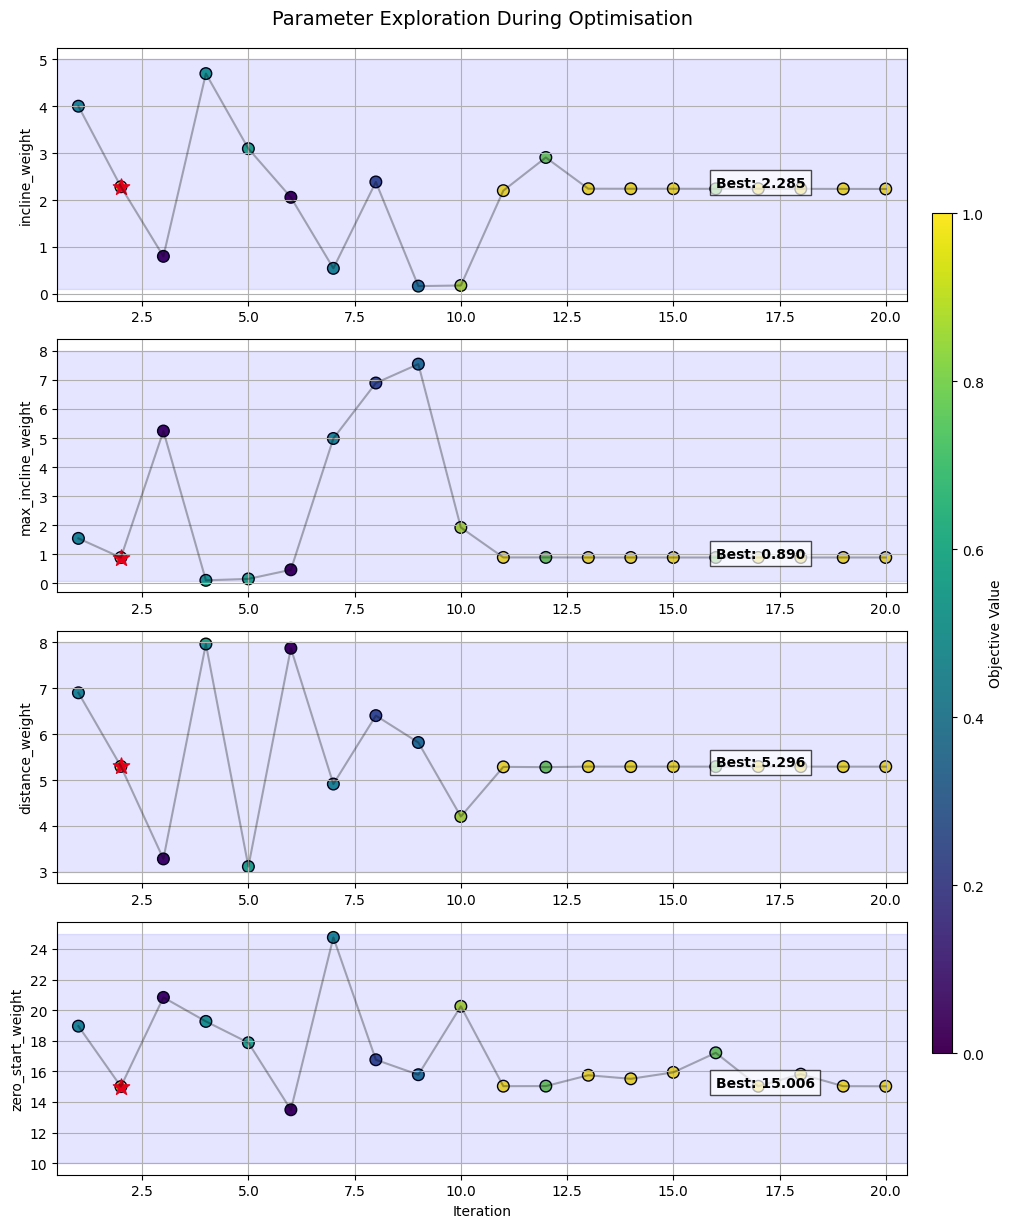

In [22]:
def plot_parameter_exploration(result):
    # Extract all evaluated points
    X = np.array(result.x_iters)
    y = np.array(result.func_vals)
    
    # Create a figure with subplots for each parameter
    param_names = ['incline_weight', 'max_incline_weight', 'distance_weight', 'zero_start_weight']
    fig, axes = plt.subplots(len(param_names), 1, figsize=(10, 12))
    
    # Color points by their objective value (darker = better)
    normalized_y = (y - np.min(y)) / (np.max(y) - np.min(y))
    colors = plt.cm.viridis(1 - normalized_y)
    
    # Plot each parameter's exploration
    for i, (ax, param_name) in enumerate(zip(axes, param_names)):
        # Extract this parameter's values
        param_values = X[:, i]
        
        # Scatter plot: x-axis is iteration, y-axis is parameter value
        iterations = range(1, len(param_values) + 1)
        sc = ax.scatter(iterations, param_values, c=colors, s=70, edgecolor='k')
        
        # Connect points to show exploration path
        ax.plot(iterations, param_values, 'k-', alpha=0.3)
        
        # Mark the best point found
        best_idx = np.argmin(y)
        ax.scatter(best_idx + 1, param_values[best_idx], 
                  color='red', s=150, marker='*', label='Best')
        
        # Show parameter bounds
        param_range = refined_space[i]
        ax.axhspan(param_range[0], param_range[1], alpha=0.1, color='blue')
        
        ax.set_ylabel(param_name)
        ax.set_xlim(0.5, len(param_values) + 0.5)
        ax.grid(True)
        
        # Add the best value as text
        ax.text(len(iterations) * 0.8, param_values[best_idx], 
                f'Best: {param_values[best_idx]:.3f}', 
                fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
    
    # Add a colorbar for the objective value
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label('Objective Value')
    
    axes[-1].set_xlabel('Iteration')
    plt.tight_layout(rect=[0, 0, 0.94, 1])
    plt.suptitle('Parameter Exploration During Optimisation', fontsize=14, y=1.02)
    plt.savefig('parameter_exploration.png', dpi=300)
    plt.show()

# Call with your optimization result
plot_parameter_exploration(result)

/var/folders/rm/kt0pkqhs74gch9sf_rcn87180000gn/T/ipykernel_22454/195847115.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


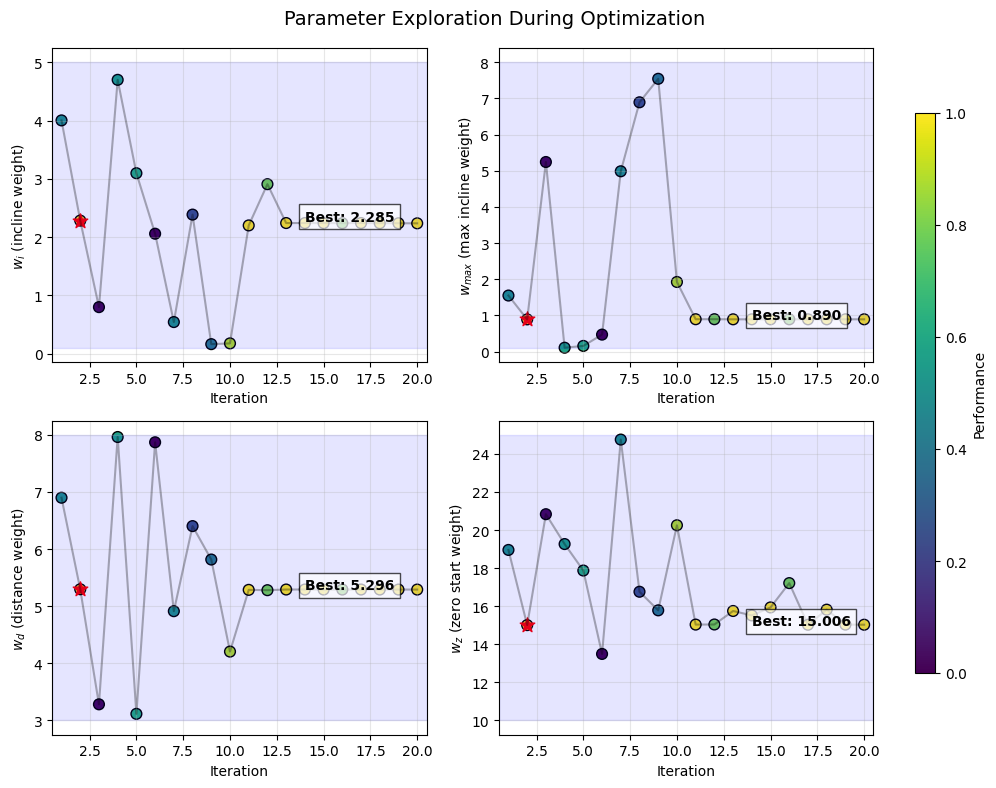

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_parameter_exploration_compact(result):
    # Extract all evaluated points
    X = np.array(result.x_iters)
    y = np.array(result.func_vals)
    
    # Create a figure with a 2x2 grid of subplots
    param_names = [r'$w_i$ (incline weight)', 
                   r'$w_{max}$ (max incline weight)', 
                   r'$w_d$ (distance weight)', 
                   r'$w_z$ (zero start weight)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()  # Flatten to easily iterate
    
    # Color points by their objective value (darker = better)
    normalized_y = (y - np.min(y)) / (np.max(y) - np.min(y))
    colors = plt.cm.viridis(1 - normalized_y)
    
    # Plot each parameter's exploration
    for i, (ax, param_name) in enumerate(zip(axes, param_names)):
        # Extract this parameter's values
        param_values = X[:, i]
        
        # Scatter plot: x-axis is iteration, y-axis is parameter value
        iterations = range(1, len(param_values) + 1)
        sc = ax.scatter(iterations, param_values, c=colors, s=60, edgecolor='k')
        
        # Connect points to show exploration path
        ax.plot(iterations, param_values, 'k-', alpha=0.3)
        
        # Mark the best point found
        best_idx = np.argmin(y)
        ax.scatter(best_idx + 1, param_values[best_idx], 
                  color='red', s=120, marker='*', label='Best')
        
        # Show parameter bounds from the search space
        param_range = refined_space[i]
        ax.axhspan(param_range[0], param_range[1], alpha=0.1, color='blue')
        
        ax.set_xlabel('Iteration')
        ax.set_ylabel(param_name)
        ax.set_xlim(0.5, len(param_values) + 0.5)
        ax.grid(True, alpha=0.3)
        
        # Add the best value as text
        ax.text(len(iterations) * 0.7, param_values[best_idx], 
                f'Best: {param_values[best_idx]:.3f}', 
                fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
    
    # Add a colorbar for the objective value
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label('Performance')
    
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.suptitle('Parameter Exploration During Bayesian Optimisation', fontsize=14)
    plt.savefig('parameter_exploration_compact.png', dpi=300)
    plt.show()

# Call with your optimization result
plot_parameter_exploration_compact(result)

In [ ]:
with open("test_data/test_input_route.json", "w") as file:
    json.dump(route_output, file, indent=4)
# After your analysis:
with open("test_data/test_output.json", "w") as file:
    json.dump(detailed_results, file, indent=4, default=lambda x: float(x) if isinstance(x, np.float64) else (int(x) if isinstance(x, np.integer) else (bool(x) if isinstance(x, np.bool_) else (x.tolist() if isinstance(x, np.ndarray) else str(x) if not isinstance(x, (str, int, float, bool, list, dict, type(None))) else x))))